In [72]:
# First we need to import all of the packages we will be using!
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [73]:
#NFKB - IKBa model

def NFKB_model(states, t, IKK_on, IKK_off, IKK_amp):
    # Our "states" list has the state variables in the following order:
    # NFKB, IKBa, NFKB:IKBa, prIKBa, NFKB:prIKBa
    NFKB = states[0]
    IKBa = states[1]
    NFKB_IKBa = states[2]
    prIKBa = states[3]
    NFKB_prIKBa = states[4]
    
    # delayed variables (prIKBa_tau, NFKB:prIKBa_tau are only those needed)
    prIKBa_tau = delay_prIKBa(t)
    NFKB_prIKBa_tau = delay_NFKB_prIKBa(t)
    
    # IKK activation
    if t > IKK_on and t < IKK_off:
        IKK = IKK_amp
    else:
        IKK = 0
   
    ### implement the change equations
    NFKB_prime = -k_a*NFKB*IKBa + k_d*NFKB_IKBa + r*IKK*NFKB_IKBa - f_a*NFKB*prIKBa +f_d*NFKB_prIKBa 
    IKBa_prime = -k_a*NFKB*IKBa + k_d*NFKB_IKBa - r*IKK*IKBa -g*IKBa + a*prIKBa_tau +b*NFKB_prIKBa_tau
    NFKB_IKBa_prime = k_a*NFKB*IKBa - k_d*NFKB_IKBa -r*IKK*NFKB_IKBa
    prIKBa_prime = -f_a*NFKB*prIKBa + f_d*NFKB_prIKBa
    NFKB_prIKBa_prime =f_a*NFKB*prIKBa - f_d*NFKB_prIKBa
    ###
    
    statesprime = [NFKB_prime, IKBa_prime, NFKB_IKBa_prime, prIKBa_prime, NFKB_prIKBa_prime]
    return statesprime

In [74]:
#delay helper functions

#these helper functions search through the ODE solution from the previous iteration 
#to give approximations of prIKBa_tau and NFKB_prIKBa_tau as needed

def delay_prIKBa(t_search):
    index = np.argmin(abs(t_search-t_index))
    return soln_hist[index, 3]
def delay_NFKB_prIKBa(t_search):
    index = np.argmin(abs(t_search-t_index))
    return soln_hist[index, 4]

In [75]:
#Steady State Simulation

#initial condition constraints
NFKB_0 = 100 #(nM)
IKBa_0 = 0
NFKB_IKBa_0 = 0 
prIKBa_0 = 1
NFKB_prIKBa_0 = 0

#parameters
k_a = 0.1 #(nM*min)^-1
k_d = 0.0006 #(min)^-1
r = 0.01 
g = 0.012
f_a = 10 
f_d = 200 
a = 0.00185
b = 5
tau = 25 #this is the parameter that will need to be varied for problem 2
        #remember to change it back to its default value (25 minutes) for problem 3

#IKK activation
IKK_on_time = 0
IKK_off_time = 0
IKK_amplitude = 0

t_final=np.array([])
soln_final = np.empty((0, 5))
states0 = [NFKB_0, IKBa_0, NFKB_IKBa_0, prIKBa_0, NFKB_prIKBa_0]
soln_hist = np.tile(states0, (1001, 1))

iterations = 20 #default number of iterations for simulation is 20

for i in range(iterations):
    # solve ODE in one period of tau, using saved values of delayed variables
    t_index = np.linspace(0,tau,1001)
    solution = odeint(NFKB_model,states0,t_index, args=(IKK_on_time, IKK_off_time, IKK_amplitude))
    
    # append new solution to array of old solution values
    t_final = np.append(t_final, (t_index[0:1000]+i*tau))
    soln_final = np.vstack((soln_final, solution[0:1000, :]))
    
    #update initial conditions solution history for next calculation
    states0 = solution[1000, :]
    soln_hist = solution
    
steady_state = soln_final[(iterations*1000)-1, :]

In [76]:
#Checking Model Implementation
#checks only work on default parameter values
print("Checks on Model Implementation:")
print("For each of the following lines ensure that your value on the right matches that on the left")
print(48.225059139469735, soln_final[1500, 0])
print(96.78765543513467, soln_final[2000, 2])
print(52.60671701101044, soln_final[4000, 1])
print(16.23230531035957, soln_final[8000, 1])
print(0.9981694760165793, soln_final[8000, 3])

Checks on Model Implementation:
For each of the following lines ensure that your value on the right matches that on the left
48.225059139469735 48.225059139469735
96.78765543513467 96.78765543513467
52.60671701101044 52.60671701101044
16.23230531035957 16.23230531035957
0.9981694760165793 0.9981694760165793


In [77]:
# NFKB responses to IKK activation

def NFKB_response(IKK_on_time, IKK_off_time, IKK_amplitude):

    IKK_on = IKK_on_time
    IKK_off = IKK_off_time
    IKK_amp = IKK_amplitude
    
    t_final=np.array([])
    soln_final = np.empty((0, 5))
    states0 = steady_state
    global soln_hist
    soln_hist = np.tile(steady_state, (1001, 1))

    iterations = 20

    for i in range(iterations):
        # solve ODE in one period of tau, using saved values of delayed variables
        global t_index
        t_index = np.linspace(0,tau,1001)
        solution = odeint(NFKB_model,states0,t_index,args=(IKK_on, IKK_off, IKK_amp))

        # append new solution to array of old solution values
        t_final = np.append(t_final, (t_index[0:1000]+i*tau))
        soln_final = np.vstack((soln_final, solution[0:1000, :]))

        #update IKK_on/off times, initial conditions, and solution history for next calculation
        IKK_on = IKK_on - tau
        IKK_off = IKK_off - tau
        states0 = solution[1000, :]
        soln_hist = solution

    return (t_final, soln_final)

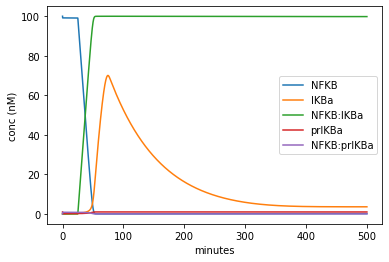

In [78]:
#Plot Dynamics - ensure steady state is reached by end of simulation
lineObjects=plt.plot(t_final, soln_final)
plt.xlabel('minutes')
plt.ylabel('conc (nM)')
plt.legend(lineObjects, ('NFKB', 'IKBa', 'NFKB:IKBa', 'prIKBa', 'NFKB:prIKBa'))

In [79]:
# Duration of NFKB response versus IKK duration
IKK_duration = [0, 0.25, 0.5, 1, 2, 5, 10, 20, 30, 60, 120] #minutes of IKK activation
NFKB_duration = [0]
NFKB_threshold = 1
for dur in IKK_duration[1:]: 
    time, soln = NFKB_response(0, dur, 10)
    count = 0
    while soln[count, 0]<NFKB_threshold:
        count = count + 1
    start = count
    while soln[count, 0]>NFKB_threshold:
        count = count + 1
    end = count
    NFKB_duration = np.append(NFKB_duration, time[end]-time[start])


Text(0, 0.5, 'Duration of NFKB response (minutes)')

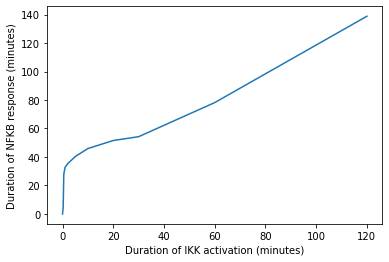

In [80]:
# Plot IKK activation versus NFKB response duration
plt.plot(IKK_duration, NFKB_duration )
plt.xlabel("Duration of IKK activation (minutes)")
plt.ylabel("Duration of NFKB response (minutes)")

Text(0, 0.5, 'NFKB (nM)')

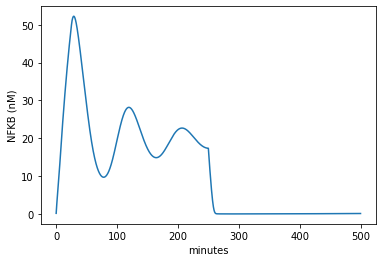

In [112]:
# NFKB response versus amplitude of IKK activation (1)
time, soln = NFKB_response(0, 250, 3) #the last argument in this function controls IKK amplitude which you will change

plt.plot(time, soln[:, 0])
plt.xlabel('minutes')
plt.ylabel('NFKB (nM)')

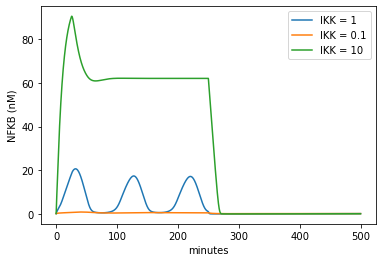

In [82]:
# NFKB response versus amplitude of IKK activation (2)
time, soln1 = NFKB_response(0, 250, 1)
time, soln2 = NFKB_response(0, 250, 0.1)
time, soln3 = NFKB_response(0, 250, 10)

plt.plot(time, soln1[:, 0], label='IKK = 1')
plt.plot(time, soln2[:, 0], label='IKK = 0.1')
plt.plot(time, soln3[:, 0], label='IKK = 10')
plt.xlabel('minutes')
plt.ylabel('NFKB (nM)')
plt.legend()